# Measuring Forgotten Learning

### Setup

In [1]:
%matplotlib notebook

import os
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


#### Neural Network

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


### Useful Functions

In [3]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
#             data = data.cpu().numpy()
            ax.plot(data)

#             if self.filled[position_id]:
#                 ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def savefig(self, filename):
        figure_path = os.path.join('plots', filename)
        os.makedirs(os.path.dirname(figure_path), exist_ok=True)
        self.fig.savefig(figure_path, bbox_inches='tight')


In [4]:
class DotDict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value


### Train Function

In [5]:
GRID_ROWS = 12
GRID_COLS = 2

class MNISTModel:
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.log_interval = 10
        self.save_model = False
        self.use_cuda = torch.cuda.is_available()
        
        self.dataset_path = os.path.join('datasets', 'mnist')

        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.loadDatasets()
        
        self.metrics = {
            'train': defaultdict(list),
            'test': defaultdict(list)
        }
        
        self.model_path = 'models'
    
    def loadDatasets(self):
        kwargs = {'num_workers': 1, 'pin_memory': True} if self.use_cuda else {}

        self.train_dataset = datasets.MNIST(
                                self.dataset_path,
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ])
                            )

        self.test_dataset = datasets.MNIST(
                                self.dataset_path,
                                train=False,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ])
                            )

        self.train_loader = torch.utils.data.DataLoader(
                                self.train_dataset,
                                batch_size=self.batch_size,
                                shuffle=True,
                                **kwargs
                            )

        self.test_loader = torch.utils.data.DataLoader(
                                self.test_dataset,
                                batch_size=self.test_batch_size,
                                shuffle=True,
                                **kwargs
                            )

        self.sorted_train_dataset, self.separated_train_dataset = self.sortDataset(self.train_dataset)

        self.sorted_train_loader = torch.utils.data.DataLoader(
                                        self.sorted_train_dataset,
                                        batch_size=self.batch_size,
                                        shuffle=False,
                                        **kwargs
                                    )
        
        self.separated_train_loader = {}
        for dataset in self.separated_train_dataset:
            self.separated_train_loader[dataset] = torch.utils.data.DataLoader(
                                                    self.separated_train_dataset[dataset],
                                                    batch_size=self.batch_size,
                                                    shuffle=False,
                                                    **kwargs
                                                )

        self.sorted_test_dataset, self.separated_test_dataset = self.sortDataset(self.test_dataset)

        self.sorted_test_loader = torch.utils.data.DataLoader(
                                        self.sorted_test_dataset,
                                        batch_size=self.test_batch_size,
                                        shuffle=False,
                                        **kwargs
                                    )
        
        self.separated_test_loader = {}
        for dataset in self.separated_test_dataset:
            self.separated_test_loader[dataset] = torch.utils.data.DataLoader(
                                                    self.separated_test_dataset[dataset],
                                                    batch_size=self.batch_size,
                                                    shuffle=False,
                                                    **kwargs
                                                )

    def sortDataset(self, dataset):
        separated_datasets = defaultdict(list)

        for datapoint in tqdm(dataset):
            separated_datasets[datapoint[1].item()].append(datapoint)

        sorted_dataset = []
        for i in range(len(separated_datasets.keys())):
            print('Class {} Size {}'.format(i, len(separated_datasets[i])))
            sorted_dataset += separated_datasets[i]

        print('Sorted Dataset Size {}'.format(len(sorted_dataset)))

        return sorted_dataset, separated_datasets
    
    def train(self, method):
        if method == 'classwise':
            for index in range(len(self.separated_train_dataset.keys())):
                print('Training Class {}'.format(index))
                self.train_by_dataset(self.separated_train_loader[index])
                self.test()
                self.savePlot('class_{}'.format(index))
        else:
            print('Training All Classes')
            self.train_by_dataset(self.train_loader)
            self.test()
            self.savePlot('class_all')

    def train_by_dataset(self, loader):
        self.model.train()
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(output, target)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            loss.backward()
            self.optimizer.step()

            self.metrics['train']['loss'].append(loss.item())
            self.metrics['train']['accuracy'].append(correct/target.shape[0])

            if (batch_idx + 1) % self.log_interval == 0:
                self.plot_grid.plot((GRID_ROWS, GRID_COLS, 1), self.metrics['train']['loss'], title='Train Loss')
                self.plot_grid.plot((GRID_ROWS, GRID_COLS, 2), self.metrics['train']['accuracy'], title='Train Accuracy')

    def test(self):
        self.model.eval()
        self.test_by_dataset(self.test_dataset, self.test_loader, (GRID_ROWS, GRID_COLS, 3), 'all')
        for index in range(len(self.separated_test_dataset.keys())):
            self.test_by_dataset(self.separated_test_dataset[index], self.separated_test_loader[index], (GRID_ROWS, GRID_COLS, 5 + (index*2)), '{}'.format(index))

    def test_by_dataset(self, dataset, loader, position, name):
        test_loss = 0
        correct = 0
        loss_key_name = 'loss_{}'.format(name)
        accuracy_key_name = 'accuracy_{}'.format(name)
        position_next = (position[0], position[1], position[2] + 1)
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                batch_loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                test_loss += batch_loss
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                batch_correct = pred.eq(target.view_as(pred)).sum().item()
                correct += batch_correct

                self.metrics['test'][loss_key_name].append(batch_loss)
                self.metrics['test'][accuracy_key_name].append(batch_correct/target.shape[0])

                if batch_idx % self.log_interval == 0:
                    self.plot_grid.plot(position, self.metrics['test'][loss_key_name], title='Test Loss {}'.format(name))
                    self.plot_grid.plot(position_next, self.metrics['test'][accuracy_key_name], title='Test Accuracy {}'.format(name))

        test_loss /= len(dataset)
        print('Test Loss {0} {1:.4f}'.format(name, test_loss))
    
    def learn(self, run_name, method='default'):
        self.run_name = run_name
        self.model = Net().to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)

        self.plot_grid = PlotGrid(figsize=(9,25))

        self.train(method)

        if (self.save_model):
            self.saveModel()
    
    def savePlot(self, epoch):
        figure_path = os.path.join(self.run_name, 'epoch_{}'.format(epoch))
        self.plot_grid.savefig(figure_path)
    
    def saveModel(self):
        model_name = 'mnist_cnn_{}.pt'.format(self.run_name)
        model_path = os.path.join(self.model_path, model_name)
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        torch.save(self.model.state_dict(), model_path)


In [6]:
mnist_model = MNISTModel()

  3%|▎         | 254/10000 [00:00<00:03, 2537.29it/s]

Class 0 Size 5923
Class 1 Size 6742
Class 2 Size 5958
Class 3 Size 6131
Class 4 Size 5842
Class 5 Size 5421
Class 6 Size 5918
Class 7 Size 6265
Class 8 Size 5851
Class 9 Size 5949
Sorted Dataset Size 60000


100%|██████████| 10000/10000 [00:03<00:00, 2832.06it/s]

Class 0 Size 980
Class 1 Size 1135
Class 2 Size 1032
Class 3 Size 1010
Class 4 Size 982
Class 5 Size 892
Class 6 Size 958
Class 7 Size 1028
Class 8 Size 974
Class 9 Size 1009
Sorted Dataset Size 10000


<IPython.core.display.Javascript object>


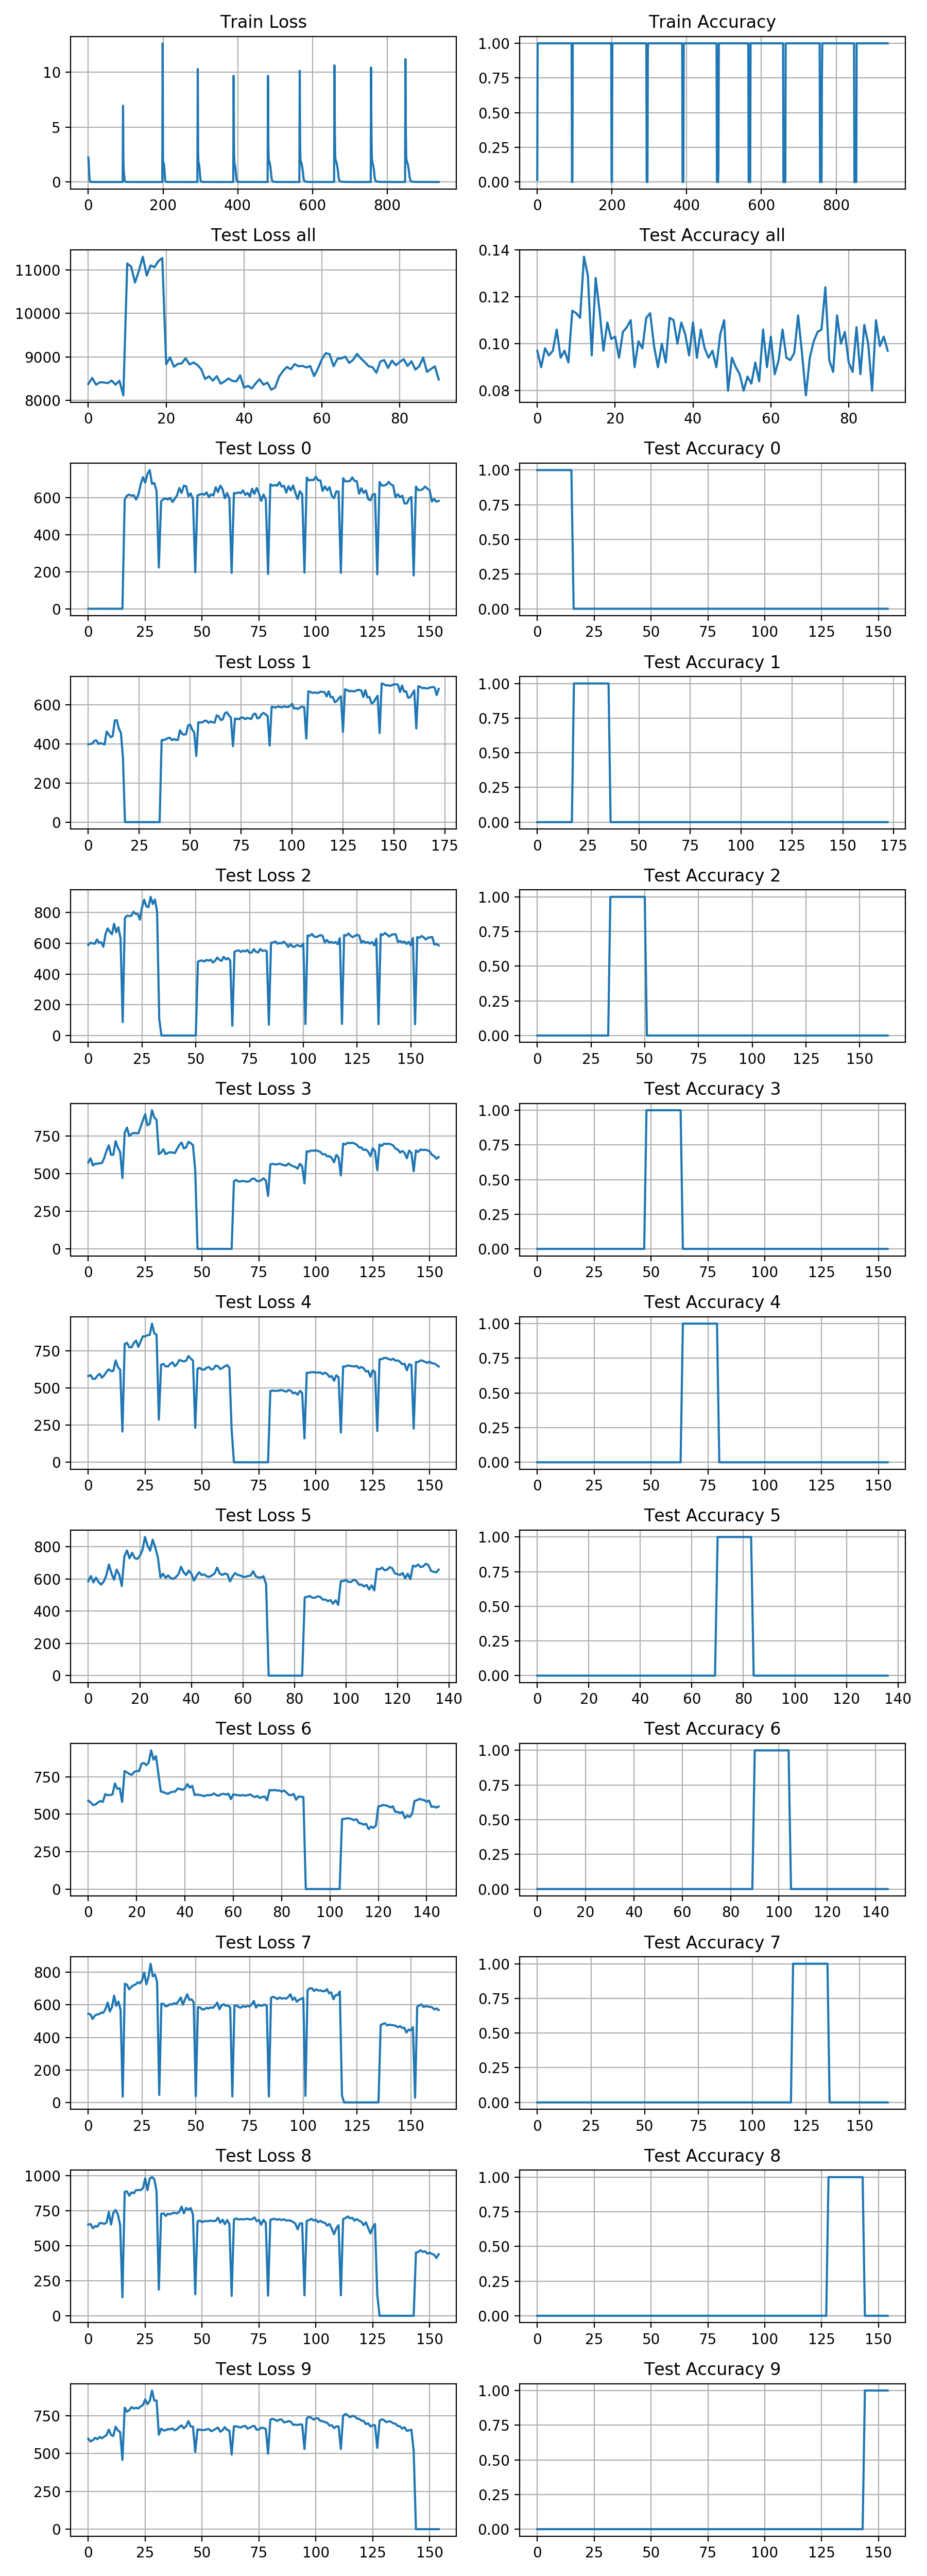

Training Class 0
Test Loss all 8.3806
Test Loss 0 0.0007
Test Loss 1 6.7962
Test Loss 2 9.9987
Test Loss 3 9.6184
Test Loss 4 9.4188
Test Loss 5 9.5304
Test Loss 6 9.6047
Test Loss 7 8.8821
Test Loss 8 10.5147
Test Loss 9 9.6482
Training Class 1
Test Loss all 11.0791
Test Loss 0 10.1985
Test Loss 1 0.0007
Test Loss 2 12.7852
Test Loss 3 12.7848
Test Loss 4 12.9561
Test Loss 5 12.1055
Test Loss 6 12.8042
Test Loss 7 11.7018
Test Loss 8 14.2672
Test Loss 9 12.8597
Training Class 2
Test Loss all 8.8450
Test Loss 0 9.5512
Test Loss 1 6.9365
Test Loss 2 0.0007
Test Loss 3 10.4242
Test Loss 4 10.5136
Test Loss 5 9.7904
Test Loss 6 10.3346
Test Loss 7 9.6410
Test Loss 8 11.5541
Test Loss 9 10.4706
Training Class 3
Test Loss all 8.4792
Test Loss 0 9.7256
Test Loss 1 8.2031
Test Loss 2 7.6740
Test Loss 3 0.0007
Test Loss 4 9.9423
Test Loss 5 9.8371
Test Loss 6 9.8360
Test Loss 7 9.1765
Test Loss 8 10.5486
Test Loss 9 10.2690
Training Class 4
Test Loss all 8.3581
Test Loss 0 9.6981
Test Loss 1 8

In [7]:
mnist_model.learn('classwise', 'classwise')